In [8]:
# Using google Colab
# Install necessary packages
#!pip install pyspark medmnist tensorflow findspark scikit-learn matplotlib

In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from medmnist import INFO, ChestMNIST
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

2024-12-01 00:47:20.728341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 00:47:20.847105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733032040.891074 1824044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733032040.903404 1824044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 00:47:21.005607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [10]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Final Project Team 19") \
    .getOrCreate()


your 131072x1 screen size is bogus. expect trouble
24/12/01 00:50:17 WARN Utils: Your hostname, JohnPC resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/01 00:50:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 00:47:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# Dataset Configuration
data_flag = 'chestmnist'
info = INFO[data_flag]

In [12]:
# Load the dataset using MedMNIST library
train_dataset = ChestMNIST(split='train', download=True)
val_dataset = ChestMNIST(split='val', download=True)
test_dataset = ChestMNIST(split='test', download=True)

Using downloaded and verified file: /home/anderson_walsh/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/anderson_walsh/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/anderson_walsh/.medmnist/chestmnist.npz


In [13]:
X_train, X_val, X_test = train_dataset.imgs, val_dataset.imgs, test_dataset.imgs


In [14]:
# Convert multi-label data to binary (0 or 1)
def convert2Binary(labels):
    return np.where(labels.sum(axis=1) > 0, 1, 0)


In [15]:
# Apply binary conversion to labels
y_train = convert2Binary(train_dataset.labels)
y_val = convert2Binary(val_dataset.labels)
y_test = convert2Binary(test_dataset.labels)

In [16]:
# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [17]:
# Rebalance the Dataset (Over-sampling minority class)
def rebalance_data(X, y):
    X_negative = X[y == 0]
    y_negative = y[y == 0]
    X_positive = X[y == 1]
    y_positive = y[y == 1]

    # Over-sample positive class
    X_positive_oversampled, y_positive_oversampled = resample(
        X_positive, y_positive,
        replace=True,
        n_samples=len(y_negative),
        random_state=42
    )

    # Combine oversampled positive and negative samples
    X_balanced = np.vstack((X_negative, X_positive_oversampled))
    y_balanced = np.hstack((y_negative, y_positive_oversampled))

    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    return X_balanced[indices], y_balanced[indices]


In [18]:
# Rebalance training data
X_train_balanced, y_train_balanced = rebalance_data(X_train, y_train)


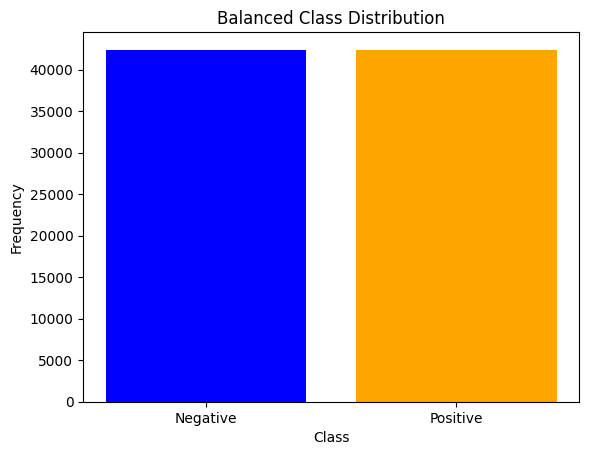

In [19]:
# Visualize Class Distribution
def plot_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique, ['Negative', 'Positive'])
    plt.show()

plot_class_distribution(y_train_balanced, title="Balanced Class Distribution")

In [21]:
# Define the CNN model using keras
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733032076.485971 1824044 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,257 (876.00 KB)

 Trainable params: 224,065 (875.25 KB)

 Non-trainable params: 192 (768.00 B)

In [24]:
# Train the Model using Keras
history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20


I0000 00:00:1733032090.433613 1825794 service.cc:148] XLA service 0x7fc11801f240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733032090.433889 1825794 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-01 00:48:10.480961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733032090.647367 1825794 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-01 00:51:02.099884: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_s

 135/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5746 - loss: 0.8365

I0000 00:00:1733032091.859615 1825794 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6085 - loss: 0.6863 - val_accuracy: 0.6504 - val_loss: 0.6422
Epoch 2/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6417 - loss: 0.6453 - val_accuracy: 0.6475 - val_loss: 0.6387
Epoch 3/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6500 - loss: 0.6375 - val_accuracy: 0.5992 - val_loss: 0.6695
Epoch 4/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6567 - loss: 0.6332 - val_accuracy: 0.6287 - val_loss: 0.6451
Epoch 5/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6633 - loss: 0.6259 - val_accuracy: 0.6645 - val_loss: 0.6325
Epoch 6/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6727 - loss: 0.6151 - val_accuracy: 0.6595 - val_loss: 0.6325
Epoch 7/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6751 - loss: 0.6119 - val_accuracy: 0.5829 - val_loss: 0.6830
Epoch 8/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6813 - loss: 0.6052 - val_accurac

In [25]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.66


702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


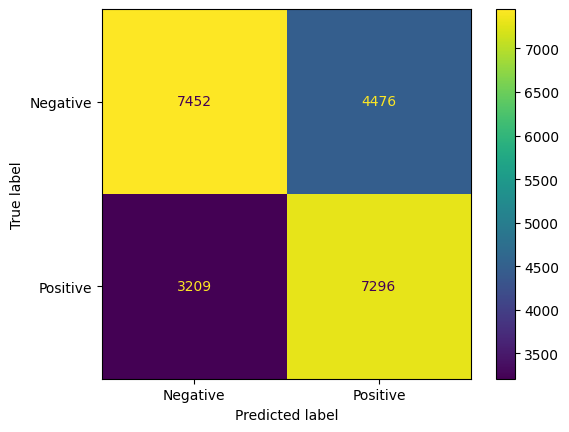

In [26]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative', 'Positive'])
plt.show()

In [27]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.62      0.66     11928
    Positive       0.62      0.69      0.66     10505

    accuracy                           0.66     22433
   macro avg       0.66      0.66      0.66     22433
weighted avg       0.66      0.66      0.66     22433



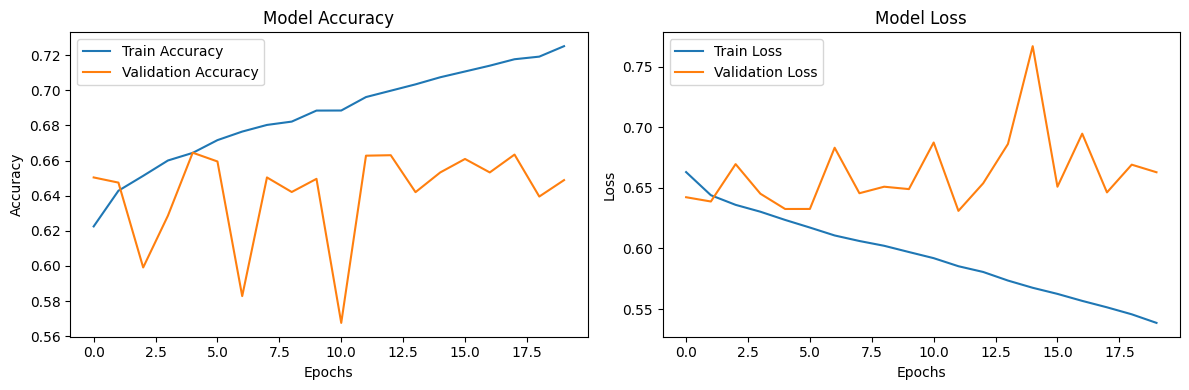

In [28]:
# Training History Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
